In [16]:
from pydantic import BaseModel, Field
from typing_extensions import Literal, TypedDict
from pydantic import Field
#from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langgraph.graph import END, StateGraph, START
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import WebBaseLoader
from typing import Annotated, List
import operator
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.types import Send
from IPython.display import Markdown, Image

from dotenv import load_dotenv

In [17]:
# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

In [18]:
class SharedState(TypedDict):
    research_topic: str
    model: ChatGroq(model_name="llama-3.3-70b-versatile")
    sections: list[Section]
    section_contents: Annotated[list[str], operator.add]
    final_report: str

In [ ]:
def build_model(shared_state: SharedState) ->  :
    shared_state['model'] =  ChatGroq(model_name="llama-3.3-70b-versatile")
    return shared_state

In [20]:
def orchestrator(shared_state: SharedState) -> SharedState:
    model = shared_state['model']
    orchestrator_prompt = ChatPromptTemplate.from_template(
        "Create a detailed outline for a research report on the topic of {research_topic}. "
        "Break the report down into sections, each with a name and brief description. "
        "Limit the report to at max 5 sections."
    )

    model_with_structured_output = model.with_structured_output(Sections)
    retrieval_grader = orchestrator_prompt | model_with_structured_output
    result = retrieval_grader.invoke(
        {
            "research_topic": shared_state['research_topic'],
        }
    )
    shared_state['sections'] = [section for section in result.sections]

    return shared_state

In [21]:
def display_sections(sections: List[Section]) -> None:
    md_content = "## Report Sections\n"
    for idx, section in enumerate(sections, start=1):
        md_content += f"### Section {idx}: {section.name}\n{section.description}\n\n"
    display(Markdown(md_content))

In [22]:
load_dotenv()

shared_state = build_model({'research_topic': 'The impact of AI on modern education.'})
shared_state = orchestrator(shared_state)

display_sections(shared_state['sections'])

## Report Sections
### Section 1: Introduction to AI in Education
This section will introduce the concept of AI in education, its current state, and the purpose of the report.

### Section 2: Benefits of AI in Education
This section will explore the benefits of AI in education, including personalized learning, improved student outcomes, and increased efficiency.

### Section 3: Challenges and Limitations of AI in Education
This section will discuss the challenges and limitations of AI in education, including bias, lack of standardization, and job displacement.

### Section 4: Case Studies and Examples
This section will provide real-world examples and case studies of AI implementation in education, highlighting successes and failures.

### Section 5: Conclusion and Future Directions
This section will summarize the key findings and provide recommendations for future research and implementation of AI in education.



In [23]:
# Worker state
class WorkerState(TypedDict):
    section: Section
    model:  ChatGroq(model_name="llama-3.3-70b-versatile")
    completed_sections: Annotated[list, operator.add]

In [24]:
def worker(worker_state: WorkerState) -> SharedState:
    """Worker writes a section of the report"""
    print(f"\nWorker Spawned! Working on section: {worker_state['section'].name}")
    model = worker_state['model']
    section = worker_state['section']
    # Generate section
    section = model.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {section.name} and description: {section.description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"section_contents": [section.content]}

In [25]:
# Conditional edge function to create llm_call workers that each write a section of the report
def spawn_workers(shared_state: SharedState):
    """Assign a worker to each section in the plan"""
    model = shared_state["model"]
    # Kick off section writing in parallel via Send() API
    return [
        Send("worker", {"section": section, "model": model}) 
        for section in shared_state["sections"]
    ]

In [26]:
def synthesizer(shared_state: SharedState):
    """Synthesize full report from sections"""

    # List of completed sections
    section_contents = shared_state["section_contents"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(section_contents)

    return {"final_report": completed_report_sections}

In [27]:
def build_workflow():
    # Build workflow
    orchestrator_worker_builder = StateGraph(SharedState)

    # Add the nodes
    orchestrator_worker_builder.add_node("build_model", build_model)
    orchestrator_worker_builder.add_node("orchestrator", orchestrator)
    orchestrator_worker_builder.add_node("worker", worker)
    orchestrator_worker_builder.add_node("synthesizer", synthesizer)

    # Add edges to connect nodes
    orchestrator_worker_builder.add_edge(START, "build_model")
    orchestrator_worker_builder.add_edge("build_model", "orchestrator")
    orchestrator_worker_builder.add_conditional_edges(
        "orchestrator", spawn_workers, ["worker"]
    )
    orchestrator_worker_builder.add_edge("worker", "synthesizer")
    orchestrator_worker_builder.add_edge("synthesizer", END)

    # Compile the workflow
    return orchestrator_worker_builder.compile()

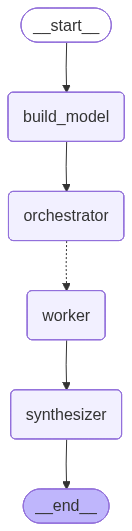

In [28]:
orchestrator_worker = build_workflow()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [29]:
state = orchestrator_worker.invoke({"research_topic": "How to prepare for a System Design technical Interview?"})

Markdown(state["final_report"])


Worker Spawned! Working on section: Introduction to System Design Interviews

Worker Spawned! Working on section: Fundamentals of System Design

Worker Spawned! Working on section: Preparation Strategies and Resources

Worker Spawned! Working on section: Common System Design Interview Questions

Worker Spawned! Working on section: Conclusion and Final Tips


### Introduction to System Design Interviews
System design interviews are a crucial part of the technical interview process for software engineering and related roles. These interviews assess a candidate's ability to design and architect complex systems, evaluate trade-offs, and communicate technical ideas effectively. 
#### Importance of System Design Interviews
The importance of system design interviews lies in their ability to evaluate a candidate's:
* Technical expertise and problem-solving skills
* Ability to work with complex systems and scalability
* Understanding of system performance, reliability, and maintainability
* Communication and collaboration skills
#### What to Expect
In a system design interview, candidates can expect to be presented with a problem or scenario that requires them to design a system or component. The interview typically involves:
* **Problem statement**: A clear description of the problem or scenario
* **Requirements gathering**: Discussion of the system's functional and non-functional requirements
* **System design**: Candidate presents a high-level design of the system, including components, interactions, and trade-offs
* **Q&A and discussion**: Interviewer asks questions to clarify the design, evaluate trade-offs, and assess the candidate's thought process
* **Feedback and evaluation**: Interviewer provides feedback on the design and evaluates the candidate's performance based on the company's requirements and expectations.

---

### Fundamentals of System Design
#### Key Concepts
* **Scalability**: The ability of a system to handle increased load and usage without compromising performance. This can be achieved through horizontal scaling (adding more servers) or vertical scaling (increasing the power of existing servers).
* **Availability**: The degree to which a system is operational and accessible when needed. This is often measured as a percentage of uptime, with high-availability systems aiming for 99.99% or higher.
* **Maintainability**: The ease with which a system can be modified, updated, or repaired. This includes factors such as code readability, modularity, and testing.

#### Design Principles
* **Separation of Concerns**: Dividing a system into independent components, each responsible for a specific function or concern. This improves maintainability and scalability.
* **Loose Coupling**: Minimizing dependencies between components, allowing for greater flexibility and easier modification.
* **High Cohesion**: Ensuring that each component has a clear, well-defined purpose and is self-contained.
* **Fault Tolerance**: Designing a system to continue operating even in the event of component failures or errors.

#### System Design Patterns
* **Load Balancing**: Distributing incoming traffic across multiple servers to improve responsiveness and availability.
* **Caching**: Storing frequently accessed data in a faster, more accessible location to reduce latency and improve performance.
* **Database Replication**: Maintaining multiple copies of a database to ensure data availability and durability.
* **Microservices Architecture**: Breaking down a system into smaller, independent services that communicate with each other through APIs.

---

### Preparation Strategies and Resources
To prepare for system design interviews, it's essential to have a comprehensive understanding of the subject matter and practice solving problems. The following are some effective ways to prepare:
#### Practice Problems
* LeetCode: A popular platform for practicing coding challenges, including system design problems
* Pramp: A platform that offers free coding challenges and mock interviews
* Glassdoor: A website that provides information on companies, including interview questions and reviews
#### Study Materials
* **Books**: "Designing Data-Intensive Applications" by Martin Kleppmann, "System Design Primer" by Donne Martin, and "Design Patterns: Elements of Reusable Object-Oriented Software" by Erich Gamma
* **Online Courses**: Coursera, edX, and Udemy offer courses on system design and software engineering
* **Blogs and Websites**: All Things Distributed, High Scalability, and System Design Primer are excellent resources for learning about system design
#### Interview Tips
* **Practice Whiteboarding**: Practice explaining system design concepts and solutions on a whiteboard
* **Learn to Estimate**: Practice estimating the scalability and performance of systems
* **Be Prepared to Ask Questions**: Come prepared with questions to ask the interviewer about the company and the role
* **Review Common System Design Concepts**: Review concepts such as load balancing, caching, and database design
By following these preparation strategies and utilizing the provided resources, candidates can effectively prepare for system design interviews and increase their chances of success.

---

### Common System Design Interview Questions
#### Architecture
* Design a chat application with a large user base
* Create a scalable e-commerce platform
* Develop a system for real-time analytics
* Design a high-performance caching system
* Build a system for load balancing and autoscaling

#### Data Storage
* Design a database for storing large amounts of user data
* Create a system for data warehousing and business intelligence
* Develop a NoSQL database for handling high traffic
* Design a cloud-based file storage system
* Build a system for data encryption and security

#### Network Design
* Design a content delivery network (CDN) for video streaming
* Create a system for network traffic optimization
* Develop a firewall and intrusion detection system
* Design a virtual private network (VPN) for secure remote access
* Build a system for network monitoring and troubleshooting

#### Additional Topics
* Design a system for handling high availability and fault tolerance
* Create a system for continuous integration and deployment
* Develop a system for microservices architecture
* Design a system for serverless computing
* Build a system for machine learning and artificial intelligence integration

---

### Conclusion and Final Tips
To ace a system design technical interview, it is essential to have a deep understanding of the fundamentals of system design, including scalability, availability, maintainability, and performance. Key takeaways from this topic include:
* Understanding the requirements and constraints of the system
* Identifying the key components and interfaces of the system
* Designing for scalability, availability, and performance
* Considering trade-offs and making informed design decisions
* Communicating design decisions and trade-offs effectively
Final tips for success include:
* Practicing whiteboarding and diagramming system designs
* Staying up-to-date with industry trends and technologies
* Reviewing common system design patterns and architectures
* Preparing to back up design decisions with data and trade-off analysis
* Demonstrating a willingness to iterate and refine the design based on feedback and new information.